<br>

# Curate A Dataset

This notebook curates the Yelp reviews dataset and ensures there are no duplicates, null values, and considers only restaurant establishments that are still in business.  

#### The end result of this notebook is the creation of a clean `reviews_dataset.csv` that will be used in subsequent `Jupyter` notebooks.  

<br>

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell

In [2]:
%matplotlib inline

# Set dataframe options to keep long data in columns from being truncated with ellipsis (...)
pd.set_option('max_colwidth', None)

# Set dataframe options to force display max columns
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_rows', 90)

InteractiveShell.ast_node_interactivity = "all"

Helper functions that is used throughout this notebook.  

In [3]:
def create_dataframe(file_path):
    '''
    Create a pandas dataframe from a JSON file indicated by the parameter file_path
    '''
    with open(file_path, encoding="utf8") as f:
        data = [json.loads(jsonObj) for jsonObj in f]
        
    return pd.DataFrame(data)


def df_info(df):
    '''
    A helper function - similar in functionality with `df.info()` but includes combined features: df.columns, df.dtypes, 
    df.isnull(), df.info(), df.nunique()
    '''
    print('\nShape : {}'.format(df.shape))
    print('Number of duplicates : {}\n'.format(df.duplicated().sum()))

    print('{:^35} {:^12} {:^12} {:^8} {:>10}\n'.format('COLUMNS', 'DATA TYPE', 'HAS NULL', 'COUNTS', '# UNIQUE'))
    for i, v in enumerate(df.columns):
        col = df[v]
        dtype = type(col.iloc[0]).__name__
        
        if dtype=='dict':
            keys = set([item for val in col.values if val is not None for item in list(val.keys())])
            col_nunique = len(keys)
        else:
            col_nunique = col.nunique()
        
        print(' {:>2}.  {:<30} {:<12} {:^10} {:>8} {:>10}'.format(i+1, v, dtype, \
                                                                  str(col.isnull().any()), col.count(), \
                                                                  col_nunique))    # col.nunique()

## Reviews Dataset

In [4]:
review_json = '../yelp_dataset/yelp_academic_dataset_review.json'
reviews_df = create_dataframe(review_json)
df_info(reviews_df)


Shape : (8021122, 9)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  review_id                      str            False     8021122    8021122
  2.  user_id                        str            False     8021122    1968703
  3.  business_id                    str            False     8021122     209393
  4.  stars                          float64        False     8021122          5
  5.  useful                         int64          False     8021122        266
  6.  funny                          int64          False     8021122        209
  7.  cool                           int64          False     8021122        200
  8.  text                           str            False     8021122    7999488
  9.  date                           str            False     8021122    7853102


> **Note :** There are `8M` instances in this dataset. With this size, training a model will take time to complete.

The problem domain is around sentiment analysis of reviews.  
The reviews are stored in the `text` feature.  Other features in the reviews dataset are not needed and can be removed.  

In [5]:
reviews_dataset = reviews_df.drop(['review_id', 'user_id', 'useful', 'funny', 'cool', 'date'], axis=1)

Since this is a type of classification type of problem, the `stars` need to be collated into three class labels, namely: `negative` (0), `neutral`(1), and `positive`(2).  Before collating, review distribution of the ratings.

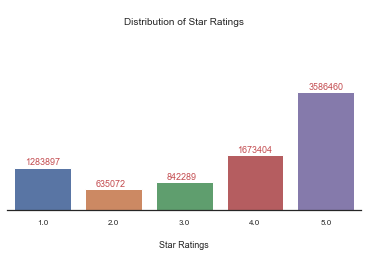

In [6]:
sns.set(style="white")
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 
          'axes.labelsize' : 9, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=True, figsize=(5, 2.4))
ax = fig.gca()
sns.countplot(reviews_dataset.stars, ax=ax)

counts=reviews_dataset.groupby('stars').count().text
for i, txt in enumerate(ax.get_xticklabels()):
    count = counts[float(txt.get_text())]
    ax.text(i-.25, count+100000, '{}'.format(count), fontdict={'fontsize': 9}, c='r')

ax.set_xlabel('\nStar Ratings')
ax.yaxis.set_visible(False)
fig.suptitle('\nDistribution of Star Ratings', y=1.42, fontsize=10);
ax.set_xticklabels(labels=[lbl.get_text().title() for lbl in ax.get_xticklabels()]);


> Patrons rate establishments from 1 through 5 with 5 being the highest. The stars value will be able to provide the appropriate label to the sentiments.
However in lieu of the star ratings, this can be collated into: negative, neutral, positive. Reviews with 1 and 2 will fall into the negative, 3 into neutral, 4 and 5 into positive.

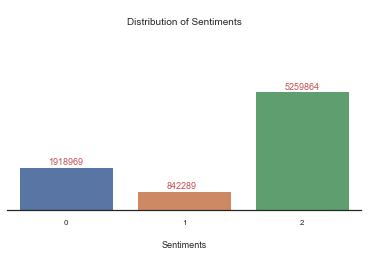

In [7]:
# this maps stars 1-2 -> 0, 3 - > 1, 4-5 -> 2 where 0 negative, 1 neutral, 2 is positive
reviews_dataset['sentiment'] = reviews_dataset['stars'].map({1:0, 2:0, 3:1, 4:2, 5:2}, na_action='ignore')

sns.set(style="white")
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 
          'axes.labelsize' : 9, 'xtick.labelsize' : 8, 'ytick.labelsize' : 8}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=True, figsize=(5, 2.4))
ax = fig.gca()
sns.countplot(reviews_dataset.sentiment, ax=ax)

counts=reviews_dataset.groupby('sentiment').count().text
for i, txt in enumerate(ax.get_xticklabels()):
    count = counts[int(txt.get_text())]
    ax.text(i-.15, count+100000, '{}'.format(count), fontdict={'fontsize': 9}, c='r')

ax.set_xlabel('\nSentiments')
ax.yaxis.set_visible(False)
fig.suptitle('\nDistribution of Sentiments', y=1.42, fontsize=10);
ax.set_xticklabels(labels=[lbl.get_text().title() for lbl in ax.get_xticklabels()]);

> **Note :** Clearly there is an imbalance data.  The imbalance is addressed in a separate notebook.

**Test the changes**.  All three queries should **not** return any values.

In [8]:
reviews_dataset.query('stars == 3 and (sentiment == 2 or sentiment == 0)')
reviews_dataset.query('stars < 3 and (sentiment == 1 or sentiment == 2)')
reviews_dataset.query('stars > 3 and (sentiment == 0 or sentiment == 1)')

,business_id,stars,text,sentiment


,business_id,stars,text,sentiment


,business_id,stars,text,sentiment


Now that the sentiment feature has been created, there is no need for the stars feature and can be removed.

In [9]:
reviews_dataset.drop(['stars'], inplace=True, axis=1)

# Review changes made on this dataset.
df_info(reviews_dataset)


Shape : (8021122, 3)
Number of duplicates : 16063

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     8021122     209393
  2.  text                           str            False     8021122    7999488
  3.  sentiment                      int64          False     8021122          3


From above `Number of duplicates`, it seems duplicates now appear in the dataset and needs to be investigated.  
> Duplicates means that there are rows whose columns have the same value as another row/instance.

In [10]:
reviews_dataset[1000:12500][reviews_dataset[1000:12500].duplicated(subset=['text'], keep=False)]

,business_id,text,sentiment
1542,wjLgM9Ybe5shoUPRrGMmsQ,"Food is consistently good here. Portions are adequate, but the service can be slow.\n\nThe space is tight, and parking can be an issue in lawrenceville.",0
10470,wjLgM9Ybe5shoUPRrGMmsQ,"Food is consistently good here. Portions are adequate, but the service can be slow.\n\nThe space is tight, and parking can be an issue in lawrenceville.",0


> Selecting a subset/range of rows from the dataset, confirms that there are indeed duplicates.  It seems that after converting the JSON object into a dataframe, the `duplicated` function did not seem to work initially that's why it did not show up in the first round of review of the dataset.

Duplicates have no value and is a waste in resource so these need to be dropped.

In [11]:
reviews_dataset.drop_duplicates(inplace=True)

# Confirm duplicates no longer exist.
df_info(reviews_dataset)


Shape : (8005059, 3)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     8005059     209393
  2.  text                           str            False     8005059    7999488
  3.  sentiment                      int64          False     8005059          3


> It is odd that the unique counts for `text` does not match total counts.

Check for duplicates only on text column.  There may be duplicates in text but vary in sentiment. If this is indeed true, this will affect the prediction performance of the model.

In [12]:
reviews_dataset[10000:30000][reviews_dataset[10000:30000].text.duplicated(keep=False)]

,business_id,text,sentiment
17351,7sb2FYLS2sejZKxRYF9mtg,"Update: \n\nAlright. So even though Sakana has its days when it's super amazing. Sometime I shake my head and wonder wth is going on. Today I have officially been eating here consistently for over a year. I just met the third owner of Sakana and am wondering how is it that she co-owns this place and was puzzled when I asked for half rolls... the manager was in a panic the entire time and somehow we got someone else's roll, and jacob didn't get half of this order. Do NOT try the wasabi taco. It is soooooo Gross. And apparently week day service is absolute shit. To add to that, the only reason why we got a table so quickly is because the couple got up and left since they hadn't been serviced yet. Did I mention it took my boyfriend 25 minutes to get his credit card back. \n\n\n\n\n-------\nI rarely give high reviews. But I really like this place. My boyfriend and I come here all the time, at least 3 times a month. This place is really well priced for what they have. \n\n$23-25 all you can eat sushi, including drinks, appetizers and desserts. \n\nAs far as the quality of the sushi, it's not fantastic but pretty good. \n\nThe only downside I would have to say is, don't experiment too much. I love trying different things but usually end up regretting most of my choices. The appetizer, ""the shit"" is probably the best experimental item on the menu.\n\nYou may have to wave down the server a few times to order unless you sit at the bar, you only have to wave them down for non roll items",0
21136,7sb2FYLS2sejZKxRYF9mtg,"Update: \n\nAlright. So even though Sakana has its days when it's super amazing. Sometime I shake my head and wonder wth is going on. Today I have officially been eating here consistently for over a year. I just met the third owner of Sakana and am wondering how is it that she co-owns this place and was puzzled when I asked for half rolls... the manager was in a panic the entire time and somehow we got someone else's roll, and jacob didn't get half of this order. Do NOT try the wasabi taco. It is soooooo Gross. And apparently week day service is absolute shit. To add to that, the only reason why we got a table so quickly is because the couple got up and left since they hadn't been serviced yet. Did I mention it took my boyfriend 25 minutes to get his credit card back. \n\n\n\n\n-------\nI rarely give high reviews. But I really like this place. My boyfriend and I come here all the time, at least 3 times a month. This place is really well priced for what they have. \n\n$23-25 all you can eat sushi, including drinks, appetizers and desserts. \n\nAs far as the quality of the sushi, it's not fantastic but pretty good. \n\nThe only downside I would have to say is, don't experiment too much. I love trying different things but usually end up regretting most of my choices. The appetizer, ""the shit"" is probably the best experimental item on the menu.\n\nYou may have to wave down the server a few times to order unless you sit at the bar, you only have to wave them down for non roll items",2


> As feared, there is indeed duplicate reviews and most concerning, sentiment is different.

Get a count of this anomaly.

In [35]:
dup_revews_idx = reviews_dataset[reviews_dataset.text.duplicated(keep=False)].index
len(dup_revews_idx)

10545

To avoid confusing the model, drop duplicates in the `text` feature.  However, which one should be kept since duplicate text reviews vary in sentiment.  Its difficult to gauge which of the review is genuine so all these are discarded instead.

In [47]:
reviews_dataset.drop(dup_revews_idx, inplace=True)

# confirm
print('Number of duplicates in "text" column : {}'.format(reviews_dataset.text.duplicated().sum()))

Number of duplicates in "text" column : 0


## Business Dataset

Reviews are from different type of establishments. This needs to be filtered down to only dine/drink type of establishments where our sentiment analysis will focus on.  To determine the type of establishments, the business dataset will need to be loaded where it contains features that can be keyed on for filtering.  

In [49]:
business_json = '../yelp_dataset/yelp_academic_dataset_business.json'
business_df = create_dataframe(business_json)
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   address       209393 non-null  object 
 3   city          209393 non-null  object 
 4   state         209393 non-null  object 
 5   postal_code   209393 non-null  object 
 6   latitude      209393 non-null  float64
 7   longitude     209393 non-null  float64
 8   stars         209393 non-null  float64
 9   review_count  209393 non-null  int64  
 10  is_open       209393 non-null  int64  
 11  attributes    180348 non-null  object 
 12  categories    208869 non-null  object 
 13  hours         164550 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 22.4+ MB


#### Restaurants Only

The `categories` feature holds the information for the type of establishment.  This will be used to filter the data.

In [51]:
# Business criteria: Restaurants, Bars, Pub, or wherever there's Food
eat_drink_business_df = business_df.query('not categories.isnull() and \
                  (categories.str.contains("Food") or categories.str.contains("Restaurants") \
                   or categories.str.contains("Bars") or categories.str.contains("Pub"))', 
                  engine='python')

eat_drink_business_df[['name', 'categories']].sample(5)

,name,categories
203839,The Edge Bar & Grill,"American (Traditional), Nightlife, Restaurants, Pool Halls"
73732,Porchetta,"Restaurants, Sandwiches, Fast Food, Italian"
175538,Wendy's,"Fast Food, Restaurants, Burgers"
158549,Nacho Daddy,"Burgers, Restaurants, Vegan, Tex-Mex, Sports Bars, Nightlife, American (New), Mexican, Breakfast & Brunch, Pubs, Bars"
109604,Moxie's Grill & Bar,"Steakhouses, Canadian (New), Burgers, Lounges, Restaurants, Nightlife, Asian Fusion, Bars, American (Traditional), American (New)"


> Sample data of the type of establishments where customer reviews will come from.

<br>

#### Establishments that are still in business

The `is_open` feature of the business dataset indicates whether or not the establishment is still in business or not.

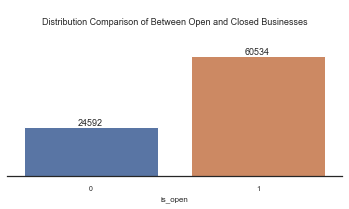

In [56]:
results = eat_drink_business_df.is_open
params = {'axes.spines.top':False, 'axes.spines.right': False, 'axes.spines.left': False, 'axes.labelsize' : 8, 
          'xtick.labelsize' : 7, 'axes.titlesize':9}
matplotlib.rcParams.update(params)
fig = plt.figure(constrained_layout=False, figsize=(6, 2.3))
ax = fig.gca()
tmp = ax.set_title('\nDistribution Comparison of Between Open and Closed Businesses\n\n');
p = sns.countplot(x=results, ax=ax)
ax.yaxis.set_visible(False)
counts=pd.Series(results).value_counts().sort_values(ascending=True)
for i, count in enumerate(counts):
    tmp = ax.text(i-.08, count+1000, '{}'.format(count), fontsize=9);


> Proportion of businesses that are still open.

<br>

Filter the restaurants/bars that are still in business.

In [63]:
establishments_still_in_business = eat_drink_business_df.query('is_open == 1').business_id
reviews_dataset = reviews_dataset.query('business_id in @establishments_still_in_business')
df_info(reviews_dataset)


Shape : (4719874, 3)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  business_id                    str            False     4719874      60534
  2.  text                           str            False     4719874    4719874
  3.  sentiment                      int64          False     4719874          3


In [64]:
len(reviews_dataset)/len(reviews_df)

0.588430645986933

> Considering only restaurant type establishments and those that are still in business, the reviews dataset is reduced to `59%` of its original size but with `4.7M` it is still a substantial size of data.

The `business_id` is no longer needed and can be removed.

In [65]:
reviews_dataset.drop(['business_id'], axis=1, inplace=True)

#### Persist changes and load dataset and review.

In [66]:
# Persist changes to a separate file.
reviews_dataset.to_csv('../yelp_dataset/reviews_dataset.csv', index=False)

As a sanity check, load the data and review.

In [67]:
temp = pd.read_csv('../yelp_dataset/reviews_dataset.csv')
df_info(temp)


Shape : (4719874, 2)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  text                           str             True     4719873    4719873
  2.  sentiment                      int64          False     4719874          3


> Initially the dataset did not have any NA values but after re-loading, it now appears we do. This is because 'N/A' was interpreted as string during JSON conversion but is now recognized by pandas as a NA value after reloading the dataset.  

Since NA values in text does not provide any meaningful data, these will have to be dropped.  Verify change one more time and then persist the new updates.

In [68]:
# drop nulls
temp.dropna(inplace=True)
df_info(temp)


Shape : (4719873, 2)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  text                           str            False     4719873    4719873
  2.  sentiment                      int64          False     4719873          3


> Dataset looks much cleaner.

In [69]:
# Persist changes.
temp.to_csv('../yelp_dataset/reviews_dataset.csv', index=False)